**The Wiener filter is defined as:**
W(u,v) = H*(u,v) / (|H(u,v)|² + K)
Where:
H*(u,v) is the complex conjugate of the degradation function
|H(u,v)|² is the power spectrum of the degradation
K is the noise-to-signal power ratio (NSR = Pn/Ps)

The advantages of the Wiener filter over inverse filtering are:

**Noise Handling:**
Unlike inverse filtering which amplifies noise at frequencies where H(u,v) is small, Wiener filter balances between inverse filtering and noise suppression
The K parameter controls this trade-off

**Adaptive Behavior:**
At frequencies where |H(u,v)|² >> K:
Acts like inverse filter (good signal)
At frequencies where |H(u,v)|² << K:
Suppresses noise (poor signal)

**Parameter K:**
Small K: More aggressive restoration but more noise
Large K: More noise suppression but more blur
Optimal K depends on noise level and image characteristics

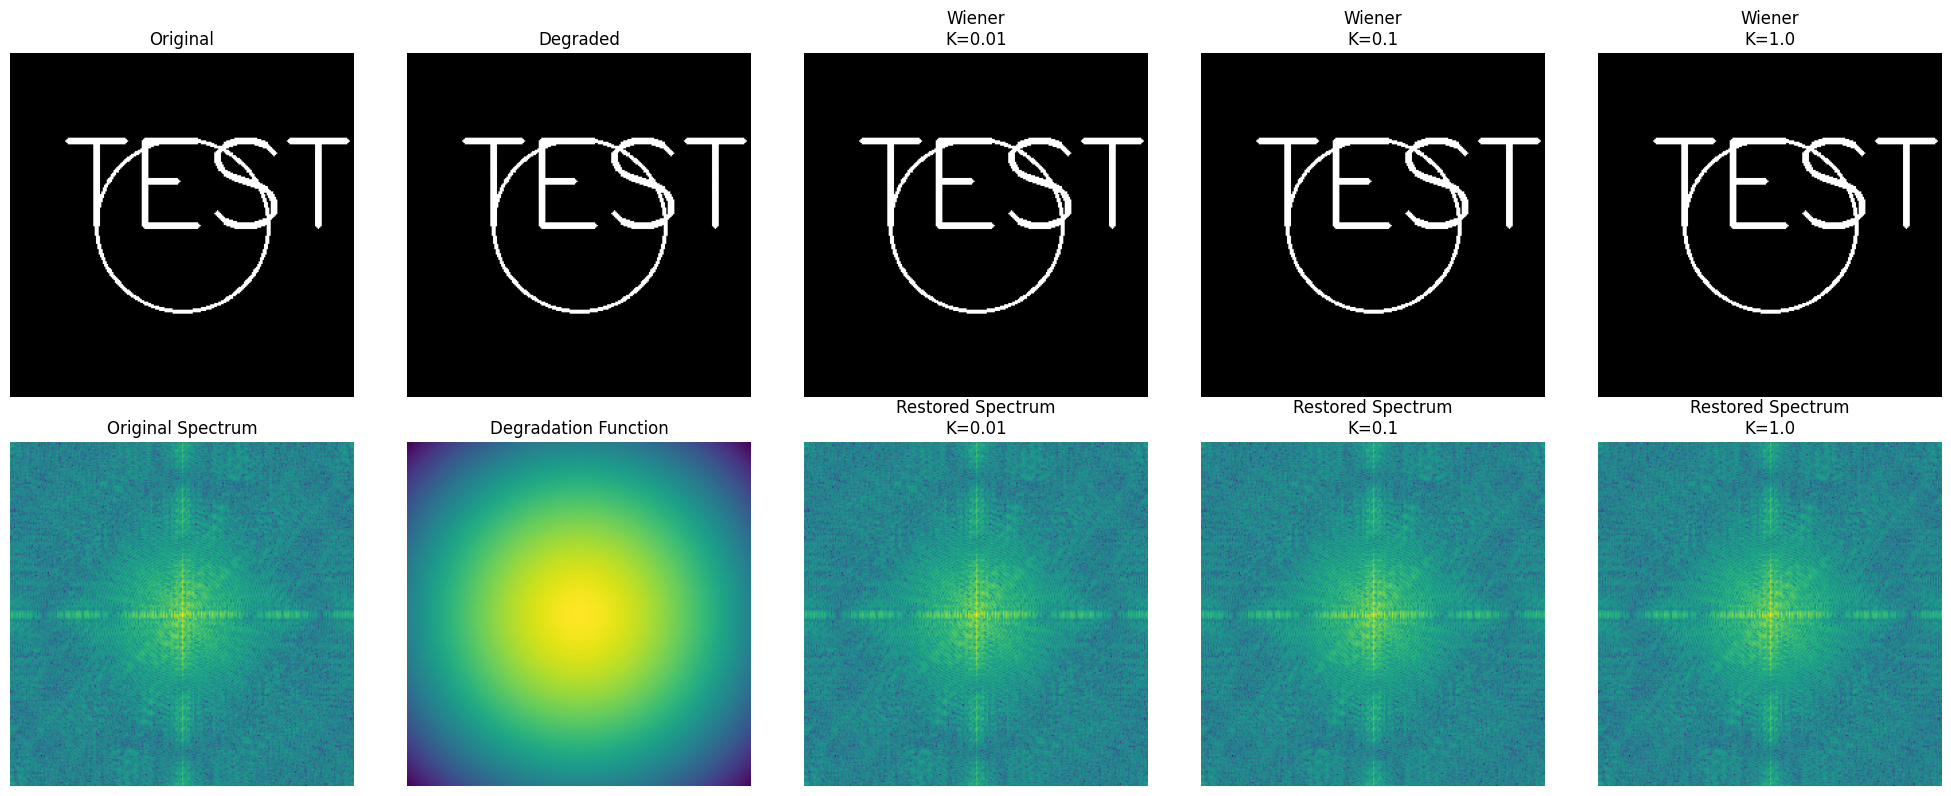

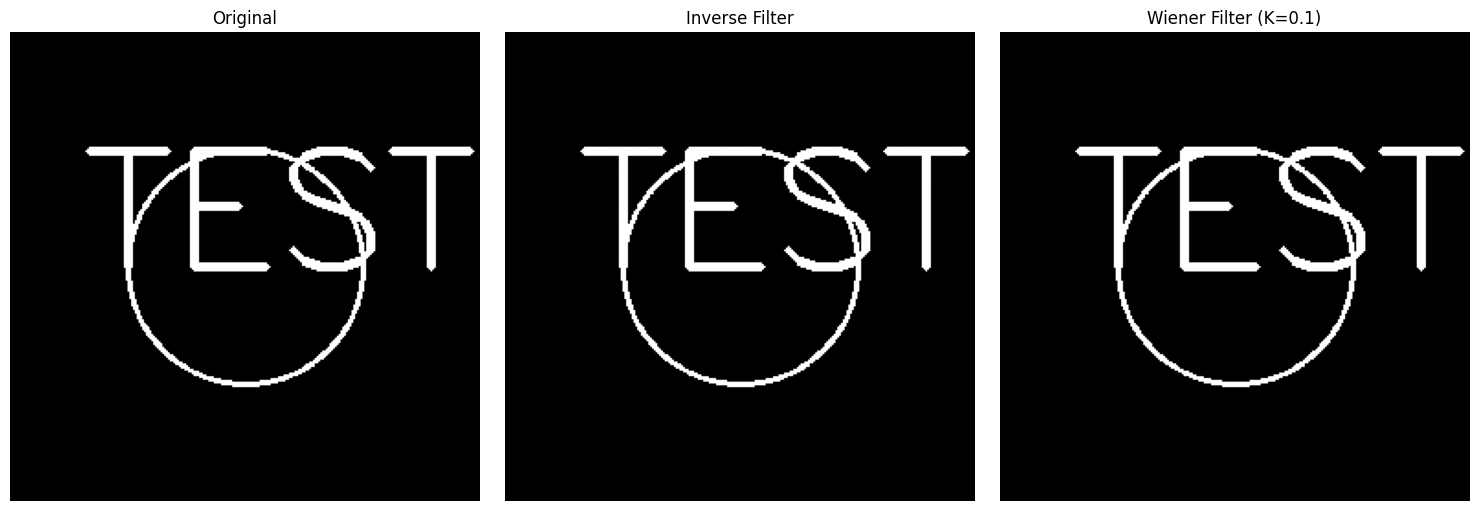

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def create_frequency_grid(M, N):
    """Create frequency grid for MxN image."""
    u = np.fft.fftfreq(M)
    v = np.fft.fftfreq(N)
    u, v = np.meshgrid(u, v)
    return u, v

def atmospheric_degradation(u, v, k=0.0025):
    """
    Atmospheric turbulence degradation function
    H(u,v) = exp(-k((u-M/2)^2 + (v-N/2)^2)^(5/6))
    """
    r_squared = (u**2 + v**2)
    H = np.exp(-k * (r_squared)**(5/6))
    return H

def wiener_filter(G, H, K):
    """
    Apply Wiener filter restoration.

    Args:
        G: Fourier transform of degraded image
        H: Degradation function
        K: Noise-to-signal power ratio

    Returns:
        F_hat: Estimate of original image spectrum
    """
    H_conj = np.conjugate(H)
    H_mag_squared = np.abs(H)**2

    # Wiener filter formula
    W = H_conj / (H_mag_squared + K)

    # Apply filter
    F_hat = W * G

    return F_hat

def process_image_wiener(image, k=0.0025, noise_std=0.01, K_values=[0.01, 0.1, 1.0]):
    """Process image with Wiener filter using different K values."""
    # Convert to float
    img_float = image.astype(float) / 255.0

    # Get frequency grid
    M, N = image.shape
    u, v = create_frequency_grid(M, N)

    # Calculate degradation function
    H = atmospheric_degradation(u, v, k)

    # Apply degradation
    F = np.fft.fft2(img_float)
    G = H * F

    # Add noise in frequency domain
    noise = np.random.normal(0, noise_std, G.shape) + 1j * np.random.normal(0, noise_std, G.shape)
    G = G + noise

    # Get degraded image
    g = np.real(np.fft.ifft2(G))
    degraded = np.clip(g * 255, 0, 255).astype(np.uint8)

    # Apply Wiener filtering with different K values
    restored_images = []
    for K in K_values:
        F_hat = wiener_filter(G, H, K)
        f_hat = np.real(np.fft.ifft2(F_hat))
        restored = np.clip(f_hat * 255, 0, 255).astype(np.uint8)
        restored_images.append(restored)

    return degraded, restored_images, H

def visualize_results(original, degraded, restored_images, H, K_values):
    """Visualize original, degraded, and restored images."""
    n_images = len(restored_images) + 2  # +2 for original and degraded
    fig, axes = plt.subplots(2, n_images, figsize=(20, 8))

    # First row: Images
    axes[0,0].imshow(original, cmap='gray')
    axes[0,0].set_title('Original')
    axes[0,0].axis('off')

    axes[0,1].imshow(degraded, cmap='gray')
    axes[0,1].set_title('Degraded')
    axes[0,1].axis('off')

    for i, (restored, K) in enumerate(zip(restored_images, K_values)):
        axes[0,i+2].imshow(restored, cmap='gray')
        axes[0,i+2].set_title(f'Wiener\nK={K}')
        axes[0,i+2].axis('off')

    # Second row: Frequency spectra
    axes[1,0].imshow(np.log1p(np.abs(np.fft.fftshift(np.fft.fft2(original)))), cmap='viridis')
    axes[1,0].set_title('Original Spectrum')
    axes[1,0].axis('off')

    axes[1,1].imshow(np.log1p(np.abs(np.fft.fftshift(H))), cmap='viridis')
    axes[1,1].set_title('Degradation Function')
    axes[1,1].axis('off')

    for i, (restored, K) in enumerate(zip(restored_images, K_values)):
        spectrum = np.fft.fftshift(np.fft.fft2(restored))
        axes[1,i+2].imshow(np.log1p(np.abs(spectrum)), cmap='viridis')
        axes[1,i+2].set_title(f'Restored Spectrum\nK={K}')
        axes[1,i+2].axis('off')

    plt.tight_layout()
    plt.show()

def compare_wiener_inverse(image, k=0.0025, noise_std=0.01, K=0.1):
    """Compare Wiener filter with inverse filter."""
    # Process with both methods
    M, N = image.shape
    u, v = create_frequency_grid(M, N)
    H = atmospheric_degradation(u, v, k)

    # Apply degradation and add noise
    F = np.fft.fft2(image.astype(float) / 255.0)
    G = H * F
    noise = np.random.normal(0, noise_std, G.shape) + 1j * np.random.normal(0, noise_std, G.shape)
    G = G + noise

    # Inverse filter
    F_hat_inv = G / (H + 1e-10)
    f_hat_inv = np.real(np.fft.ifft2(F_hat_inv))
    restored_inv = np.clip(f_hat_inv * 255, 0, 255).astype(np.uint8)

    # Wiener filter
    F_hat_wiener = wiener_filter(G, H, K)
    f_hat_wiener = np.real(np.fft.ifft2(F_hat_wiener))
    restored_wiener = np.clip(f_hat_wiener * 255, 0, 255).astype(np.uint8)

    # Visualize comparison
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(image, cmap='gray')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(restored_inv, cmap='gray')
    plt.title('Inverse Filter')
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(restored_wiener, cmap='gray')
    plt.title(f'Wiener Filter (K={K})')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def main():
    # Create or load test image
    image = cv2.imread('your_image.jpg', cv2.IMREAD_GRAYSCALE)
    if image is None:
        # Create test image
        image = np.zeros((256, 256), dtype=np.uint8)
        cv2.putText(image, 'TEST', (40, 128), cv2.FONT_HERSHEY_SIMPLEX, 3, 255, 4)
        cv2.circle(image, (128, 128), 64, 255, 2)

    # Process image with different K values
    K_values = [0.01, 0.1, 1.0]
    degraded, restored_images, H = process_image_wiener(
        image,
        k=0.001,      # Degradation strength
        noise_std=0.01,  # Noise level
        K_values=K_values
    )

    # Visualize results
    visualize_results(image, degraded, restored_images, H, K_values)

    # Compare with inverse filter
    compare_wiener_inverse(image)

if __name__ == "__main__":
    main()